Вариант: Экономика стран

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    precision_score, recall_score, accuracy_score, roc_auc_score, f1_score,
    matthews_corrcoef, cohen_kappa_score, confusion_matrix
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import featuretools as ft
from sklearn.metrics import accuracy_score, classification_report

# Функция для применения oversampling
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    return X_resampled, y_resampled

# Функция для применения undersampling
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    return X_resampled, y_resampled

def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
):
    """
    Splits a Pandas dataframe into three subsets (train, val, and test)
    following fractional ratios provided by the user, where each subset is
    stratified by the values in a specific column (that is, each subset has
    the same relative frequency of the values in the column). It performs this
    splitting by running train_test_split() twice.

    Parameters
    ----------
    df_input : Pandas dataframe
        Input dataframe to be split.
    stratify_colname : str
        The name of the column that will be used for stratification. Usually
        this column would be for the label.
    frac_train : float
    frac_val   : float
    frac_test  : float
        The ratios with which the dataframe will be split into train, val, and
        test data. The values should be expressed as float fractions and should
        sum to 1.0.
    random_state : int, None, or RandomStateInstance
        Value to be passed to train_test_split().

    Returns
    -------
    df_train, df_val, df_test :
        Dataframes containing the three splits.
    """

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X = df_input  # Contains all columns.
    y = df_input[
        [stratify_colname]
    ]  # Dataframe of just the column on which to stratify.

    # Split original dataframe into train and temp dataframes.
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )

    # Split the temp dataframe into val and test dataframes.
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test


df = pd.read_csv("../data/Economic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369 entries, 0 to 368
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stock index          369 non-null    object 
 1   country              369 non-null    object 
 2   year                 369 non-null    float64
 3   index price          317 non-null    float64
 4   log_indexprice       369 non-null    float64
 5   inflationrate        326 non-null    float64
 6   oil prices           369 non-null    float64
 7   exchange_rate        367 non-null    float64
 8   gdppercent           350 non-null    float64
 9   percapitaincome      368 non-null    float64
 10  unemploymentrate     348 non-null    float64
 11  manufacturingoutput  278 non-null    float64
 12  tradebalance         365 non-null    float64
 13  USTreasury           369 non-null    float64
dtypes: float64(12), object(2)
memory usage: 40.5+ KB


Бизнес-цель: сегментировать страны на основе экономических показателей для определения схожих групп стран и последующего анализа каждой группы.

In [54]:
data = df.copy()
data_cleaned = df.dropna()

if not np.issubdtype(data_cleaned.dtypes.iloc[1], np.number):
    print("Данные содержат текстовые значения. Убедитесь, что только числовые данные используются для анализа.")
    cleaned_data = data_cleaned.select_dtypes(include=[np.number])

print(f"Исходный размер датасета: {df.shape[0]}")
print(f"Очищенный размер датасета: {data_cleaned.shape[0]}")

data1 = pd.get_dummies(data_cleaned, columns=['country'], drop_first=True)

Данные содержат текстовые значения. Убедитесь, что только числовые данные используются для анализа.
Исходный размер датасета: 369
Очищенный размер датасета: 219


In [55]:
print(data1.columns)
print(data1.isnull().sum())
data2 = data1.drop(['stock index'], axis = 1)
data2.info()

Index(['stock index', 'year', 'index price', 'log_indexprice', 'inflationrate',
       'oil prices', 'exchange_rate', 'gdppercent', 'percapitaincome',
       'unemploymentrate', 'manufacturingoutput', 'tradebalance', 'USTreasury',
       'country_France', 'country_Germany', 'country_Hong Kong',
       'country_India', 'country_Japan', 'country_Spain',
       'country_United Kingdom', 'country_United States of America'],
      dtype='object')
stock index                         0
year                                0
index price                         0
log_indexprice                      0
inflationrate                       0
oil prices                          0
exchange_rate                       0
gdppercent                          0
percapitaincome                     0
unemploymentrate                    0
manufacturingoutput                 0
tradebalance                        0
USTreasury                          0
country_France                      0
country_Germany       

[[  -175.11730098  -8125.91541511]
 [  1359.15430649  -7976.83866444]
 [  2330.12842909  -7886.62363629]
 [  3638.58468227  -7885.49439407]
 [  4638.69365316  -7738.97353013]
 [  5921.57827905  -7533.60974468]
 [  7420.03426153  -7269.3752748 ]
 [  8823.38406687  -6981.62904291]
 [ 10508.03737208  -6093.36153206]
 [ 12357.01890855  -5087.16328305]
 [ 13108.1576432   -6856.08050495]
 [ 13984.76420629  -7375.23274241]
 [ 15460.23414568  -7307.74768791]
 [ 17685.72825995  -7028.50596781]
 [ 20090.21526684  -6980.26253392]
 [ 22277.89668445  -6874.90441336]
 [ 23962.33912597  -6605.01263864]
 [ 24446.64571772  -6845.1952535 ]
 [ 25871.01649677  -6556.01887636]
 [ 27597.98078369  -6314.0423994 ]
 [ 29116.38461377  -5778.79720501]
 [ 31080.78776834  -4997.72117578]
 [ 34067.26159619  -4464.16933609]
 [ 36188.91962302  -3273.16517374]
 [ 39173.66351113  -2162.39563038]
 [ 41402.60872282  -1707.33871091]
 [ -4920.26128698  -6264.09433006]
 [ -4107.33309919  -5936.17563897]
 [ -5591.9683601   -

C:\Users\mitat\AppData\Local\Temp\ipykernel_19512\3444879312.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, cmap='viridis')


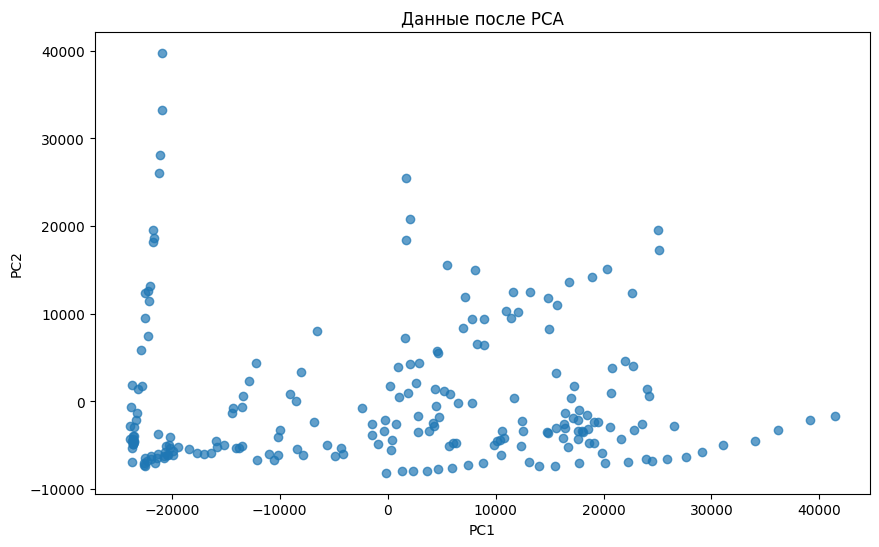

In [56]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data2)

print(reduced_data)

plt.figure(figsize=(10,6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.7, cmap='viridis')
plt.title("Данные после PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Выбор количества кластеров

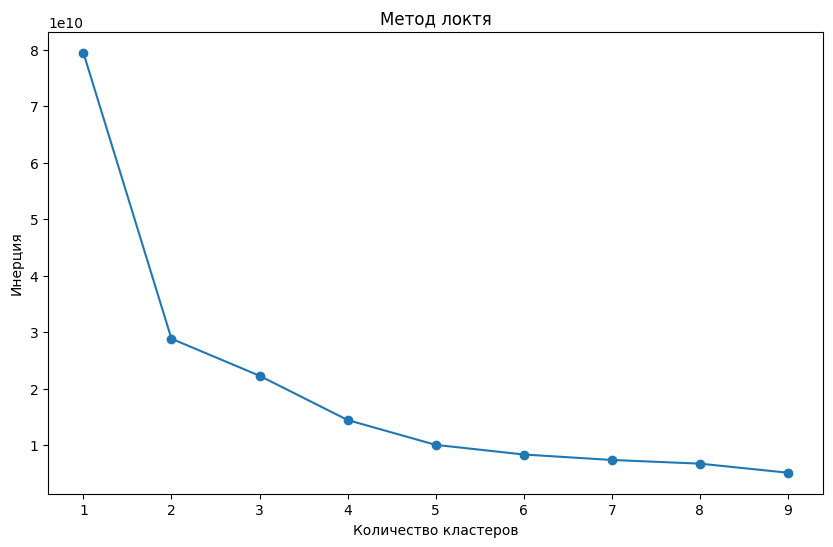

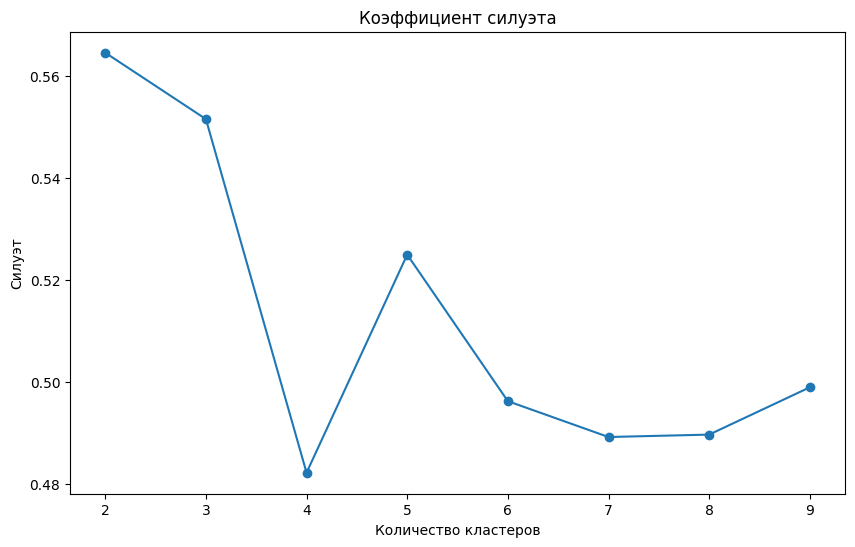

In [57]:
inertia = []
k_values = range(1, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров")
plt.ylabel("Инерция")
plt.show()

# Коэффициент силуэта для выбора оптимального количества кластеров
silhouette_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_data)
    score = silhouette_score(reduced_data, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Коэффициент силуэта")
plt.xlabel("Количество кластеров")
plt.ylabel("Силуэт")
plt.show()

Кластерны анализ

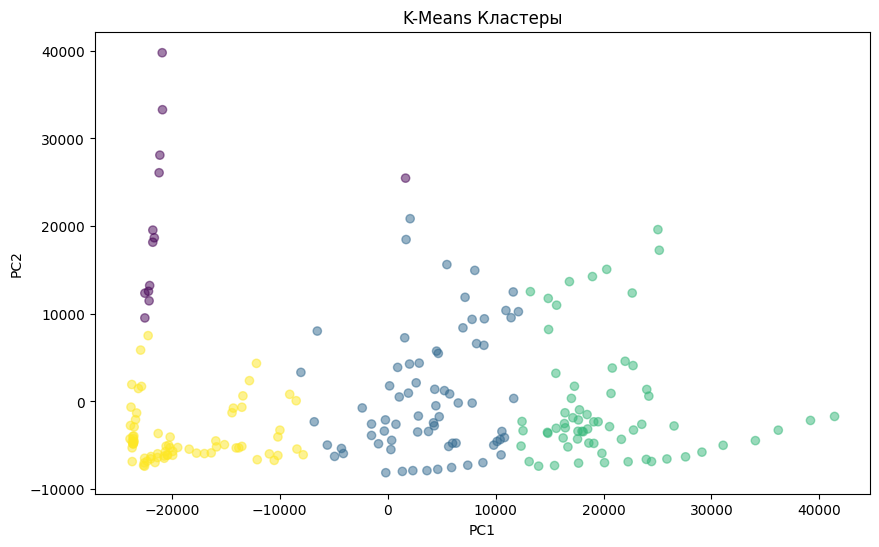

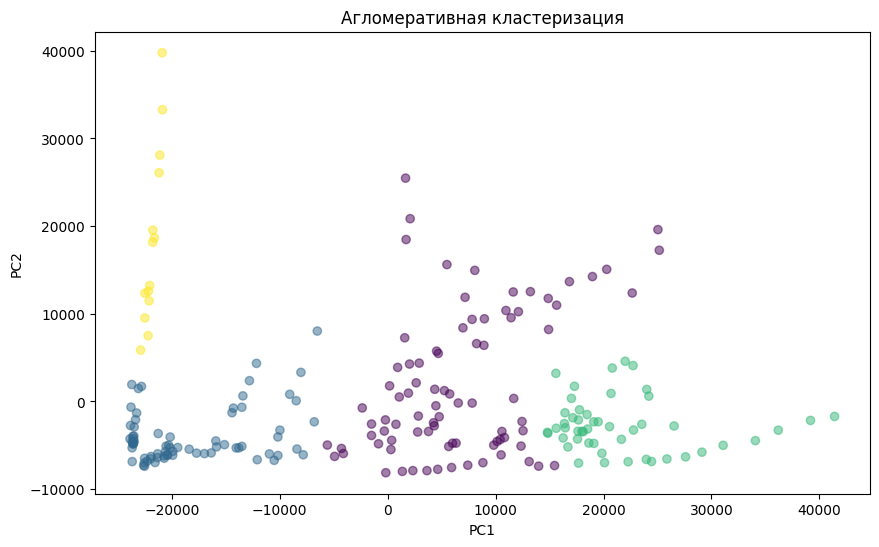

In [58]:
# Оптимальное количество кластеров
optimal_k = 4

# Неиерархическая кластеризация (K-Means)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans = kmeans.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels_kmeans, cmap='viridis', alpha=0.5)
plt.title("K-Means Кластеры")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Агломеративная кластеризация
agglomerative = AgglomerativeClustering(n_clusters=optimal_k)
agglomerative_labels = agglomerative.fit_predict(reduced_data)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=agglomerative_labels, cmap='viridis', alpha=0.5)
plt.title("Агломеративная кластеризация")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Оценка качества решения

In [59]:
# Коэффициент силуэта для K-Means
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(reduced_data, labels_kmeans)
print(f'K-Means - Инерция: {kmeans_inertia}, Коэффициент силуэта: {kmeans_silhouette}')

# Коэффициент силуэта для иерархической кластеризации
agglomerative_silhouette = silhouette_score(reduced_data, agglomerative_labels)
print(f"Коэффициент силуэта для иерархической кластеризации: {agglomerative_silhouette:.2f}")

K-Means - Инерция: 14420617136.370611, Коэффициент силуэта: 0.48226441542888965
Коэффициент силуэта для иерархической кластеризации: 0.46
